In [8]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Sparse matrix imports
from scipy.sparse import coo_matrix

# Starting a session with the API
qctrl = Qctrl()


sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_y = np.array([[0, -1j], [1j, 0]])

Optimizer

In [49]:
def optimize_pulse(H, nodes, noise, target_operation):
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=H,
        noise_operators=noise,
        target_operator=target_operation,
        name="infidelity",
    )
    optimization_result = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=nodes,
        graph=graph,
    )
    
    return optimization_result

Ideal simulation

In [3]:
def simulate_ideal_qubit(duration, values, shots, repetitions):
    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    initial_state = np.array([[1], [0]])  # Initial state of qubit in |0>

    with qctrl.create_graph() as graph:
        drive = qctrl.operations.pwc_signal(duration=duration, values=values)
        hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        state = repeated_unitary @ initial_state

        populations = qctrl.operations.abs(state[:, 0]) ** 2
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

        result = qctrl.functions.calculate_graph(
            graph=graph,
            output_node_names=["unitary", "repeated_unitary", "populations"],
        )

    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    measurements = np.random.choice(2, size=shots, p=populations)

    results = {"unitary": unitary, "measurements": measurements}

    return results

Ideal qubit, only drive:

In [4]:
duration = 5
segment_count = 10

with qctrl.create_graph() as graph:
    #Drive
    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    gamma = qctrl.operations.complex_pwc_signal(
        moduli=qctrl.operations.anchored_difference_bounded_variables(
            count=segment_count,
            lower_bound=-1,
            upper_bound=1,
            difference_bound=0.5,
        ),
        phases=qctrl.operations.unbounded_optimization_variable(
            count=segment_count,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        ),
        duration=duration,
        name="gamma",
    )
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=b)
    )
    
    # Hadamard gate
    ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    ideal_not = np.array([[0,1], [1,0]])
    target_op = qctrl.operations.target(operator=ideal_not)

    
    H = qctrl.operations.pwc_sum([drive])

    #target_op = qctrl.operations.target(operator=target_op)

    optimization_result = optimize_pulse(H, ["gamma"], [], target_op)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 6s.


Check pulse

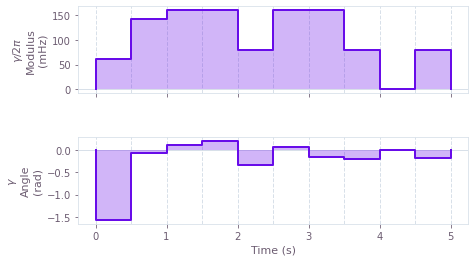

In [5]:
plot_controls(
    plt.figure(),
    controls={
        "$\\gamma$": optimization_result.output["gamma"],
    },
)
plt.show()

Simulate with ideal qubit

In [6]:
IQ = np.array([o.get("value") for o in optimization_result.output["gamma"]])

shots = 3000

IQ = np.array(list(IQ) + list(IQ))

result = simulate_ideal_qubit(duration, IQ, shots, 1)
print(sum(result.get("measurements"))/shots)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
0.0


## "Real" device

Fuction to test on simulation

In [7]:
def test_IQ(IQ, duration, segments, shot_count):
    controls = []
    values = IQ
    control_seq = {
        "duration": 10, 
        "values":values,
        "repetition_count": 1
    }
    controls.append(control_seq)
    plot_controls(
        figure=plt.figure(),
        controls={
            "$\Omega$": [
                {"duration": duration/segments, "value": value} for value in values
            ]
        },
    )
    
    experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=controls,
        shot_count=shot_count,
    )
    
    return experiment_results.measurements

Function that runs the optimizer based on the model, change values in the beginning depending on model

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 15s.
Optimized cost:	 2.388161423516821e-05


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
0.4816666666666667


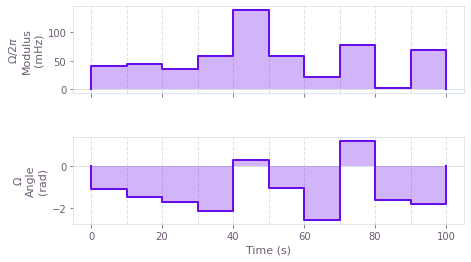

In [51]:
shot_count = 3000

duration = 100
segment_count = 10
const_X_ampl = 0.01
const_Y_ampl = 0.01
const_Z_ampl = 0.1
sigma = 0.5
mu = 31.65

T1 = 0.01
T2 = 0.1

with qctrl.create_graph() as graph:
    #Drive
    b = np.array([[0, 1], [0, 0]])  # Lowering operator

    gamma = qctrl.operations.complex_pwc_signal(
        #moduli=drive_mod_filtered,
        moduli=qctrl.operations.anchored_difference_bounded_variables(
            count=segment_count,
            lower_bound=-1,
            upper_bound=1,
            difference_bound=0.5,
        ),
        phases=qctrl.operations.unbounded_optimization_variable(
            count=segment_count,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        ),
        duration=duration,
        name="gamma",
    )

    drive_filtered = qctrl.operations.convolve_pwc(
        gamma,
        qctrl.operations.gaussian_integral_function(std=sigma, offset=mu),
    )

    drive_disc = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=segment_count
        )

    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=b)
    )

    # Const x
    const_X = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=const_X_ampl * sigma_x / 2,
    )

    # Const z
    const_Z = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=const_Z_ampl * sigma_z / 2,
    )

    # Const y
    const_Y = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=const_Y_ampl * sigma_y / 2,
    )


    # T2
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=T2 * sigma_z / duration
    )

    # T1
    depolarisation = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=T1 * b
    )

    # taget gate matrices
    ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    ideal_not = np.array([[0, 1], [1, 0]])

    #target_op = qctrl.operations.target(operator=ideal_not)
    target_op = qctrl.operations.target(operator=ideal_h_gate)


    H = qctrl.operations.pwc_sum([drive, const_X, const_Y, const_Z])

    optimization_result = optimize_pulse(H, ["gamma"], [dephasing, depolarisation], target_op)
    print("Optimized cost:\t", optimization_result.cost)

# IQ - the np.array of IQ values
IQ = np.array([o.get("value") for o in optimization_result.output["gamma"]])
results = test_IQ(IQ, duration, segment_count, shot_count)
print(sum(results[0])/shot_count)

To check the same pulses again without running the optimizer

In [57]:
shot_count = 3000
def test_IQ(IQ, dur, seg, shot_count):
    controls = []
    values = IQ
    control_seq = {
        "duration": dur, 
        "values":values,
        "repetition_count": 1
    }
    controls.append(control_seq)
    
    
    experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=controls,
        shot_count=shot_count,
    )
    
    return experiment_results.measurements


results = test_IQ(IQ, duration, segment_count, shot_count)
print(sum(results[0])/shot_count)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
0.5093333333333333
